In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib
import random
import os
import gzip

import warnings
warnings.filterwarnings('ignore')

In [8]:
def generate_available_stat(vol_df):
    grouped = vol_df.groupby('Station')
    station_dict = {}
    available_stat = []
    for name in vol_df['Station'].unique():
        station_dict[name] = grouped.get_group(name)
    #     print(station_dict[name])

        percent_missing = station_dict[name].isnull().sum() * 100 / len(station_dict[name])

        if percent_missing['Flow'] == 0 and percent_missing['Spd'] == 0:
            available_stat.append(name)
            
    return station_dict

In [3]:
def generate_link_dict(edge_df, node_df, loc_df, vol_df, station_dict, year, month, day, write_dir):
    volume_link_dict = {}
    spd_link_dict = {}
    for i in range(len(edge_df)):
        from_node_id = edge_df.loc[i,'from_node']
        to_node_id = edge_df.loc[i,'to_node']
    #     print(to_node_id)
        direction = edge_df.loc[i,'direction']
        highway = int(edge_df.loc[i,'highway'])

    #     print('direction, ', direction, ' highway, ', highway)

        lng1 = float(node_df[node_df['node_id']==from_node_id]['lng'])
        lat1 = float(node_df[node_df['node_id']==from_node_id]['lat'])
        lng2 = float(node_df[node_df['node_id']==to_node_id]['lng'])
        lat2 = float(node_df[node_df['node_id']==to_node_id]['lat'])
        eps = 0.0001
    #     print('lat1, ', lat1, 'lat2, ', lat2)
        import geopy.distance

        coords_1 = (lat1, lng1)
        coords_2 = (lat1, lng2)

        length = geopy.distance.geodesic(coords_1, coords_2).miles

    #     print(length)

        if direction == 'E'or direction == 'W':
    #         print('i am here1')
            name_list = loc_df.loc[(loc_df.Longitude <= max(lng1,lng2)+eps) \
                                        & (loc_df.Longitude >= min(lng1,lng2)-eps) \
                                        & (loc_df.Fwy == highway)\
                                        & (loc_df.Dir == direction)]['ID'].to_list()
        else:
    #         print('i am here2')
            name_list = loc_df.loc[(loc_df.Latitude <= max(lat1,lat2)+eps) \
                                        & (loc_df.Latitude >= min(lat1,lat2)-eps) \
                                        & (loc_df.Fwy == highway)\
                                        & (loc_df.Dir == direction)]['ID'].to_list()

    #     print(type(vol_df['Station']))
        tmp_df = vol_df[vol_df['Station'].isin(name_list)]
        tmp_density = pd.DataFrame()
        tmp_spd = pd.DataFrame()
    #     print('tmp_df, ', tmp_df)
        tmp_df_dict = {}
        
        for name in tmp_df['Station'].unique():
#             print('name: ', name)
#             print('station: ', station_dict[name])
            tmp_df_dict[name] = station_dict[name][['Datetime','Flow','Spd']]

            percent_missing = station_dict[name].isnull().sum() * 100 / len(station_dict[name])
            df = tmp_df_dict[name]
            
            if (percent_missing['Flow'] == 0) & (percent_missing['Spd'] == 0):
                if (tmp_df_dict[name].shape[0] < 288):
                    if (tmp_df_dict[name].shape[0] < 200):
                        print('too small: ',tmp_df_dict[name].shape[0])
                        continue
                    print('tmp_df_dict shape: ', tmp_df_dict[name].shape)
                    
                    astr = df.iloc[0,0]
                    cur_h = int(df.iloc[0,0][-8:-6])
                    cur_m = int(df.iloc[0,0][-5:-3])
                    cur_s = int(df.iloc[0,0][-2:])
                    astr2 = df.iloc[-1,0]
                    
                    
                    if (datetime.datetime(year, month, day,cur_h, cur_m,cur_s) >  datetime.datetime(year, month, day, 0, 0,0)):
                        print('first: ',df.iloc[0,0])
                        dt_new = datetime.datetime(year, month, day, 0, 0,0).strftime("%Y-%m-%d %H:%M:%S")
                        new_row = pd.DataFrame({'Datetime': dt_new, 'Flow': np.NaN, 'Spd': np.NaN}, index =[0])
                        df = pd.concat([new_row, df]).reset_index(drop = True)
                                            
                    cur_h = int(astr2[-8:-6])
                    cur_m = int(astr2[-5:-3])
                    cur_s = int(astr2[-2:])
                    
                    if (datetime.datetime(year, month, day,cur_h, cur_m,cur_s) <  datetime.datetime(year, month, day, 23, 55,0)):
                        print('last: ',df.iloc[-1,0])
                        dt_new = datetime.datetime(year, month, day, 23, 55,0).strftime("%Y-%m-%d %H:%M:%S")
                        df = df.append({'Datetime': dt_new, 'Flow': np.NaN, 'Spd': np.NaN}, ignore_index=True)
                    
                    df['Datetime'] = pd.to_datetime(df['Datetime'])
                    
                    df = df.set_index('Datetime').asfreq('5MIN').reset_index()
#                     print('df: ', df)
#                     print('df shape1: ', df.shape)
                    
                    df.fillna(method='ffill')
#                     print('nanff: ', df.isna().sum())
                    df.fillna(method='bfill')
#                     print('nanbf: ', df.isna().sum())
                    mean_flow = df['Flow'].mean()
                    mean_spd = df['Spd'].mean()
                    df['Flow'].fillna(value=mean_flow, inplace=True)
                    df['Spd'].fillna(value=mean_spd, inplace=True)
#                     print('nanmean: ', df.isna().sum())
#                     print('flow shape', df['Flow'].shape[0])
#                     print('df shape2: ', df.shape)
                    print('after fill nan shape: ', df.shape)
                if df['Flow'].shape[0] != 288 or df['Spd'].shape[0] != 288:
                    print('shape: ', df['Flow'].shape[0])
                    continue
                
                tmp_density[name] = (df['Flow']/(df['Spd']/12)).to_list()
                tmp_spd[name] = df['Spd'] #mph
                date = (pd.to_datetime(df["Datetime"]).dt.date.astype(str)).tolist()
                time = (pd.to_datetime(df["Datetime"]).dt.time.astype(str)).tolist()
        if 'date' in locals():
            tmp_density['link_flow'] = tmp_density.mean(axis=1) * length
            tmp_density["date"] = pd.to_datetime(date).date
            tmp_density["time"] = pd.to_datetime(time).time
        #     print('tmp_density, ', tmp_density)
            tmp_spd['link_spd'] = tmp_spd.mean(axis=1)
            tmp_spd["date"] = pd.to_datetime(date).date
            tmp_spd["time"] = pd.to_datetime(time).time

        #     print('index type,', type(spd_link_dict[edge_df.loc[i,'link_id']].index[0]))
        #     print('col type,', type(spd_link_dict[edge_df.loc[i,'link_id']].columns[0]))
        else:
            dt1 = datetime.datetime(year, month, day, 0, 0,0).strftime("%Y-%m-%d %H:%M:%S")
            dt2 = datetime.datetime(year, month, day, 23, 59,0).strftime("%Y-%m-%d %H:%M:%S")
            dt_col = pd.date_range(start=dt1,end=dt2,freq='5Min')
            
            tmp_density["date"] = dt_col.date
            tmp_density["time"] = dt_col.time
            tmp_density['link_flow'] = np.nan
            
#             print('tmp_density, ', tmp_density)
            tmp_spd["date"] = dt_col.date
            tmp_spd["time"] = dt_col.time
            tmp_spd['link_spd'] = np.nan
            
        volume_link_dict[edge_df.loc[i,'link_id']] = pd.pivot_table(tmp_density, index= tmp_density.date, columns=tmp_density.time, values = 'link_flow')
        #     print('index type,', type(volume_link_dict[edge_df.loc[i,'link_id']].index[0]))
        #     print('col type,', type(volume_link_dict[edge_df.loc[i,'link_id']].columns[0]))
        spd_link_dict[edge_df.loc[i,'link_id']] = pd.pivot_table(tmp_spd, index= tmp_spd.date, columns=tmp_spd.time, values = 'link_spd')
    #         df = spd_link_dict[edge_df.loc[i,'link_id']]
    #         if df.isnull().sum().sum() * 100 / len(df) != 0:
    #             print('df, ', df)
    #             print('nan not zero: ', edge_df.loc[i,'link_id'])
    #     print('volume_link_dict, ', volume_link_dict)
    import pickle
    with open(write_dir + "/volume_dict_link_"+str(year)+"_"+str(month)+"_"+str(day)+".pkl", 'wb') as handle:
        pickle.dump(volume_link_dict, handle, protocol=4)
    with open(write_dir + "/speed_dict_link_"+str(year)+"_"+str(month)+"_"+str(day)+".pkl", 'wb') as handle:
        pickle.dump(spd_link_dict, handle, protocol=4)


In [4]:
def save_as_pickle(write_dir, year, month, day):
    import pickle
    with open(write_dir + "/volume_dict_link_"+str(year)+"_"+str(month)+"_"+str(day)+".pkl", 'wb') as handle:
        pickle.dump(volume_link_dict, handle, protocol=4)
    with open(write_dir + "/speed_dict_link_"+str(year)+"_"+str(month)+"_"+str(day)+".pkl", 'wb') as handle:
        pickle.dump(spd_link_dict, handle, protocol=4)

In [6]:
import datetime
pwd = '../PeMS_rawData/station_vol/'
write_dir = './processed_data/link_dict/2022'

edge_file = "./processed_data/20200320_large/Edge_list_large.csv"
node_file = "./processed_data/20200320_large/node_list_large.csv"

edge_df = pd.read_csv(edge_file, header = [0])
node_df = pd.read_csv(node_file, header = [0])

edge_df['highway'] = edge_df.highway.str.extract(r'(\d+[.\d]*)')
edge_df['direction'] = edge_df['direction'].astype(str).str[0]

pwd_loc = '../PeMS_rawData/station_loc/'
for filename in os.listdir(pwd):
    
    year = int(filename[22:26])
    month = int(filename[27:29])
    day = int(filename[30:32])
    vol_date = datetime.date(year, month, day)
    if not ((vol_date >= datetime.date(2022, 5,1)) & (vol_date <= datetime.date(2022,9,30))):
        continue
    
    print('vol_date, ', vol_date)
    ## read in location file
    min_days = np.inf
    location_file = ''
    for file_loc in os.listdir(pwd_loc):
#         print('file_loc: ', file_loc)
        year_loc = int(file_loc[14:18])
        month_loc = int(file_loc[19:21])
        day_loc = int(file_loc[22:24])
#         print(file_loc)
#         print(year_loc)
        
        loc_date = datetime.date(year_loc, month_loc, day_loc)
        if vol_date > loc_date:
            if (vol_date - loc_date).days < min_days:
                location_file = file_loc
                min_days = (vol_date - loc_date).days
    print('location_file: ', location_file)
        
    loc_df = pd.read_csv(pwd_loc+location_file, sep="\t", header = [0])
#     print(loc_df)
#     break
            
    with gzip.open(pwd+filename, 'rb') as f:
        colnames=['Datetime', 'Station', 'Freeway', 'Direction', 'Flow', 'Spd'] 
        vol_df = pd.read_csv(f, sep=",", usecols = [0,1,3,4,9,11], names=colnames, header = None)
#         print(vol_df.head())
    station_dict = generate_available_stat(vol_df)
#     print(len(vol_df['Station'].unique()))
#     print(len(station_dict.keys()))
    generate_link_dict(edge_df, node_df, loc_df, vol_df, station_dict, year, month, day, write_dir)
        
#     break

vol_date,  2022-05-01
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (238, 3)
first:  05/01/2022 00:25:00
after fill nan shape:  (288, 3)
vol_date,  2022-06-30
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (271, 3)
first:  06/30/2022 00:25:00
after fill nan shape:  (288, 3)
vol_date,  2022-05-13
location_file:  d07_text_meta_2022_03_12.txt
vol_date,  2022-06-22
location_file:  d07_text_meta_2022_03_12.txt
too small:  199
too small:  199
too small:  127
vol_date,  2022-05-25
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (266, 3)
first:  05/25/2022 00:05:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (278, 3)
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (278, 3)
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (278, 3)
after fill nan shape:  (288, 3)
vol_date,  2022-06-14
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (256, 3)
first:  06/14/2022 00:25:00
after fill nan shape:  (288, 3)
tmp_df_dict

too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:

too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:

too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:

too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:  66
too small:

vol_date,  2022-06-26
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (269, 3)
after fill nan shape:  (288, 3)
vol_date,  2022-05-17
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (278, 3)
first:  05/17/2022 00:05:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (276, 3)
first:  05/17/2022 00:25:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (277, 3)
first:  05/17/2022 00:20:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (276, 3)
first:  05/17/2022 00:25:00
after fill nan shape:  (288, 3)
vol_date,  2022-05-05
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (255, 3)
after fill nan shape:  (288, 3)
vol_date,  2022-07-20
location_file:  d07_text_meta_2022_07_15.txt
tmp_df_dict shape:  (251, 3)
first:  07/20/2022 00:25:00
after fill nan shape:  (288, 3)
vol_date,  2022-07-16
location_file:  d07_text_meta_2022_07_15.txt
tmp_df_dict shape:  (250, 3)
first:  07/16/2022 00:05:00
after fill nan shape:  (288, 3)
vol_date,

vol_date,  2022-06-01
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (264, 3)
after fill nan shape:  (288, 3)
vol_date,  2022-07-07
location_file:  d07_text_meta_2022_03_12.txt
tmp_df_dict shape:  (282, 3)
first:  07/07/2022 00:25:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (281, 3)
first:  07/07/2022 00:25:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (281, 3)
first:  07/07/2022 00:25:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (264, 3)
first:  07/07/2022 00:25:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (282, 3)
first:  07/07/2022 00:10:00
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (282, 3)
after fill nan shape:  (288, 3)
tmp_df_dict shape:  (281, 3)
first:  07/07/2022 00:25:00
after fill nan shape:  (288, 3)
vol_date,  2022-07-19
location_file:  d07_text_meta_2022_07_15.txt
tmp_df_dict shape:  (257, 3)
first:  07/19/2022 00:20:00
after fill nan shape:  (288, 3)
vol_date,  2022-07-15
location_file:  d07_text_meta_20

In [7]:
edge_file = "./processed_data/20200320_large/Edge_list_large.csv"
node_file = "./processed_data/20200320_large/node_list_large.csv"

edge_df = pd.read_csv(edge_file, header = [0])
node_df = pd.read_csv(node_file, header = [0])

edge_df['highway'] = edge_df.highway.str.extract(r'(\d+[.\d]*)')
edge_df['direction'] = edge_df['direction'].astype(str).str[0]

718111
                    Datetime  Station  Freeway Direction  Flow  Spd
1780     03/20/2019 00:00:00   718111       10         E   NaN  NaN
6636     03/20/2019 00:05:00   718111       10         E   NaN  NaN
11492    03/20/2019 00:10:00   718111       10         E   NaN  NaN
16348    03/20/2019 00:15:00   718111       10         E   NaN  NaN
21204    03/20/2019 00:20:00   718111       10         E   NaN  NaN
...                      ...      ...      ...       ...   ...  ...
1376028  03/20/2019 23:35:00   718111       10         E   NaN  NaN
1380884  03/20/2019 23:40:00   718111       10         E   NaN  NaN
1385740  03/20/2019 23:45:00   718111       10         E   NaN  NaN
1390596  03/20/2019 23:50:00   718111       10         E   NaN  NaN
1395452  03/20/2019 23:55:00   718111       10         E   NaN  NaN

[288 rows x 6 columns]
718112
                    Datetime  Station  Freeway Direction  Flow  Spd
1781     03/20/2019 00:00:00   718112       10         E   NaN  NaN
6637     0

        718118     718421     737184     737320    737329     763447  \
0    25.144509  30.857143  33.172205  14.054054  3.692308  42.352941   
1    24.695652  30.545455  34.080717  15.472264  3.302752  45.043478   
2    24.593023  23.899018  32.581602  14.567527  3.302752  53.913043   
3    23.580786  34.238683  40.295858  14.577778  2.949309  40.386207   
4    22.740525  29.500000  37.142857  13.949329  2.769231  43.397260   
..         ...        ...        ...        ...       ...        ...   
283  32.105263  35.902965  44.283647  32.190760  4.239631  63.739837   
284  31.929825  35.789474  39.942857  35.178571  4.239631  60.160428   
285  30.526316  46.090535  45.367965  31.410658  4.055300  58.090186   
286  28.947368  36.988636  43.730273  32.392638  3.859112  51.611185   
287  27.096774  36.116505  42.536023  26.686838  3.502304  52.870494   

        763453     718150     718151  
0    29.608128   7.764706  18.395415  
1    33.000000   8.474576  18.515284  
2    29.638554   5

IndexError: range object index out of range

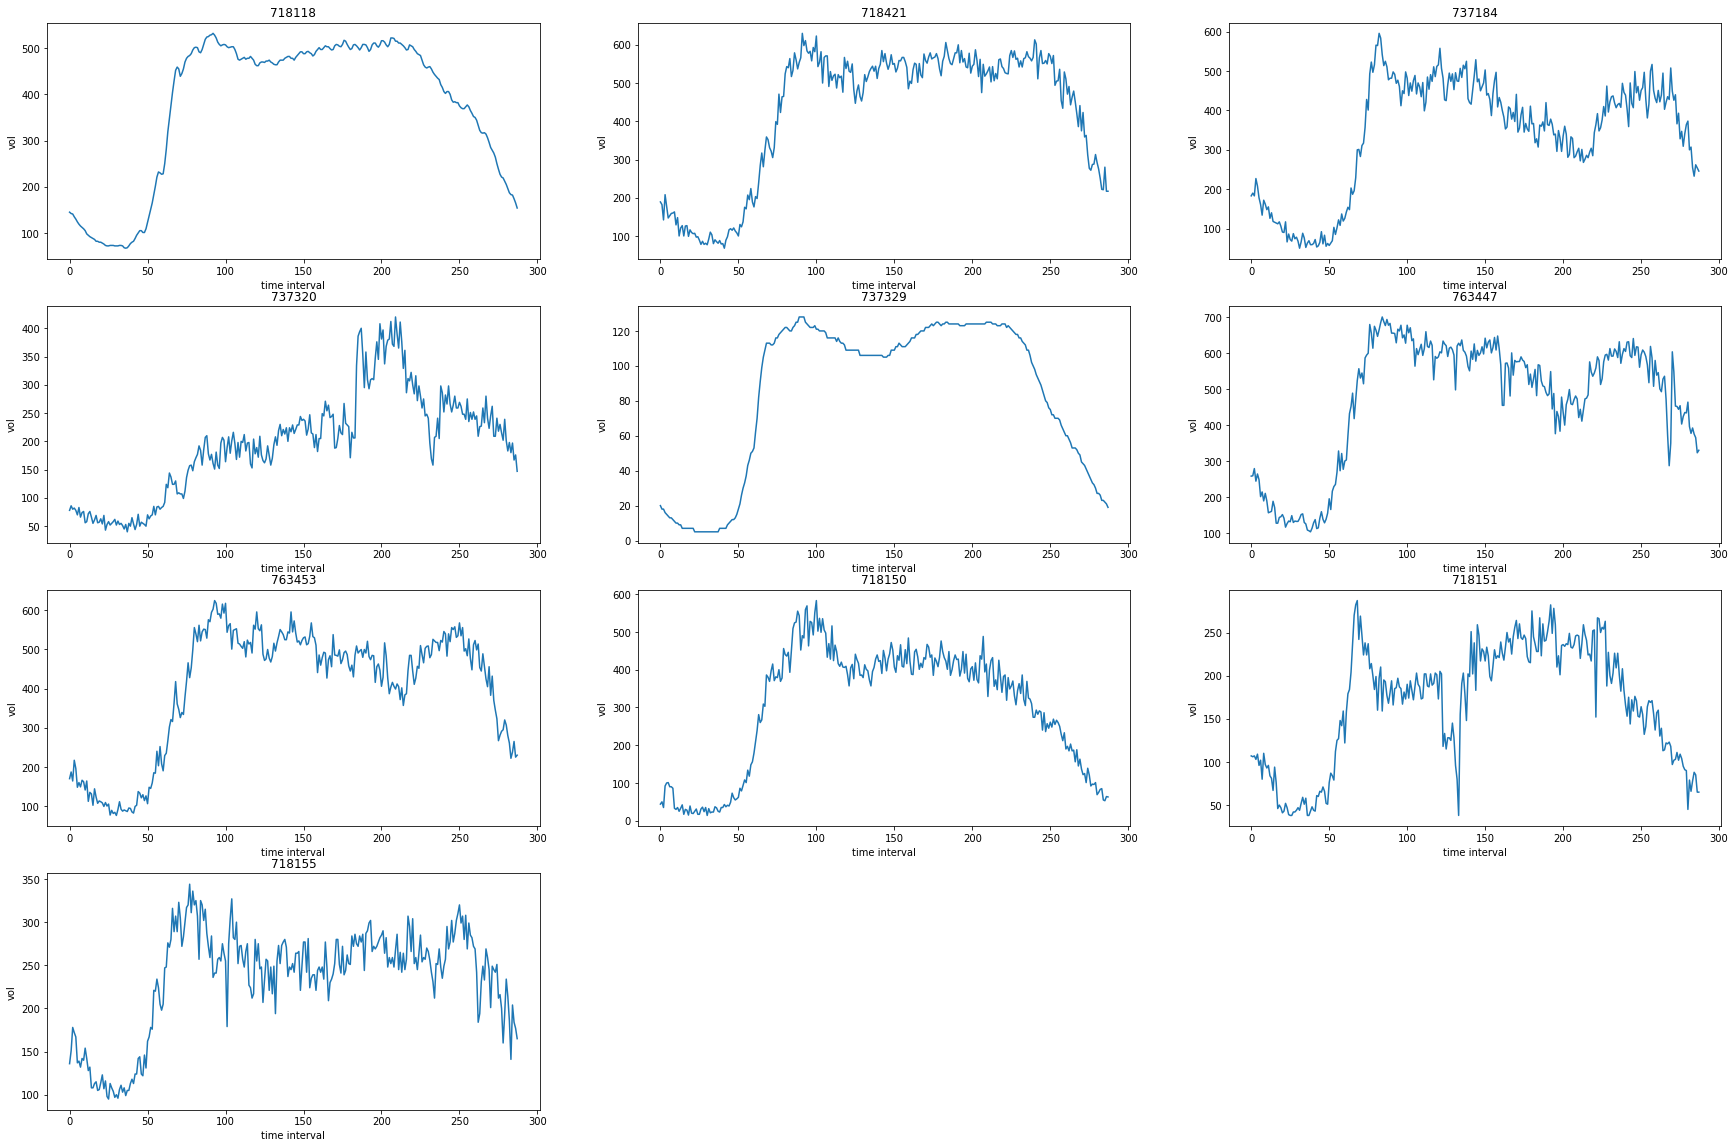

In [45]:
grouped = tmp_df.groupby('Station')
tmp_df_dict = {}
available_stat = []
tmp_density = pd.DataFrame()

Tot = 10
Cols = 3

# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

Position = range(1,Tot + 1)

fig = plt.figure(1)
k = -1
# station_dict[name]
for name in tmp_df['Station'].unique():
    tmp_df_dict[name] = station_dict[name][['Datetime','Flow','Spd']]
#     tmp_density[name] = tmp_df_dict[name]['Flow']/(tmp_df_dict[name]['Spd']/12)
    print(name)
    print(station_dict[name])
    percent_missing = station_dict[name].isnull().sum() * 100 / len(station_dict[name])
    
    
    
    if (percent_missing['Flow'] == 0) & (percent_missing['Spd'] == 0):
        print(tmp_df_dict[name])
        tmp_density[name] = (tmp_df_dict[name]['Flow']/(tmp_df_dict[name]['Spd']/12)).to_list()
        
        k +=1
        ax = fig.add_subplot(Rows,Cols,Position[k])
        x = np.array(tmp_df_dict[name]['Datetime'])
        x = np.arange(0,288,1)
    #     a = pd.DataFrame({'column_name': station_dict[name]['Datetime'],
    #                      'percent_missing': station_dict[name]['Flow']})
    #     print(a)
        ax.plot(x,tmp_df_dict[name]['Flow'])      # Or whatever you want in the subplot
        ax.set_title(name)
        ax.set_xlabel('time interval')
        ax.set_ylabel('vol')
        
        print(tmp_density)

plt.show()

tmp_density['link_flow'] = tmp_density.mean(axis=1) * length
print(tmp_density)
fig = plt.figure(2)
plt.rcParams["figure.figsize"] = (30,10)
tmp_density.plot()

In [107]:
plt.show()

        718118     718421     737184     737320    737329     763447  \
0    25.144509  30.857143  33.172205  14.054054  3.692308  42.352941   
1    24.695652  30.545455  34.080717  15.472264  3.302752  45.043478   
2    24.593023  23.899018  32.581602  14.567527  3.302752  53.913043   
3    23.580786  34.238683  40.295858  14.577778  2.949309  40.386207   
4    22.740525  29.500000  37.142857  13.949329  2.769231  43.397260   
..         ...        ...        ...        ...       ...        ...   
283  32.105263  35.902965  44.283647  32.190760  4.239631  63.739837   
284  31.929825  35.789474  39.942857  35.178571  4.239631  60.160428   
285  30.526316  46.090535  45.367965  31.410658  4.055300  58.090186   
286  28.947368  36.988636  43.730273  32.392638  3.859112  51.611185   
287  27.096774  36.116505  42.536023  26.686838  3.502304  52.870494   

        763453     718150     718151     718155     718492   link_flow  
0    29.608128   7.764706  18.395415  24.802432  30.260870   7

<AxesSubplot:>

<Figure size 2160x1440 with 0 Axes>

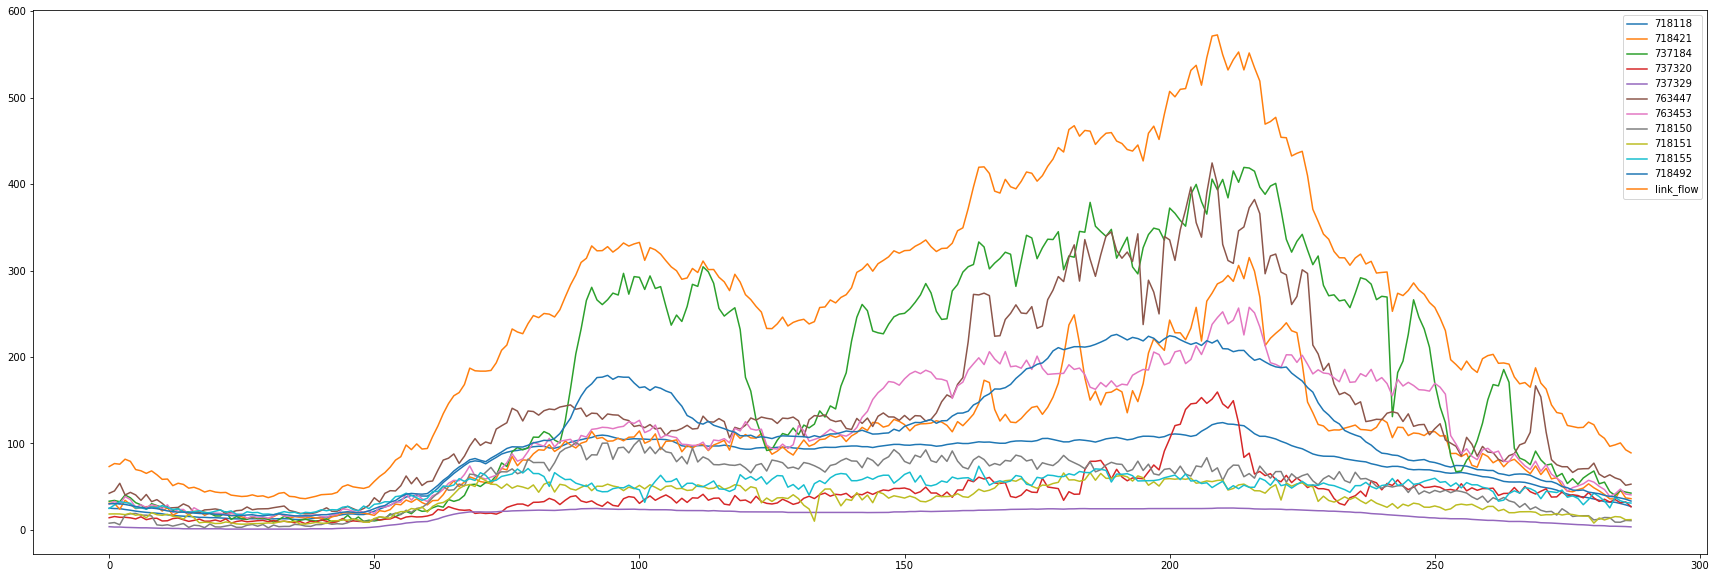

In [46]:
tmp_density['link_flow'] = tmp_density.mean(axis=1) * length
print(tmp_density)
fig = plt.figure(2)
plt.rcParams["figure.figsize"] = (30,10)
tmp_density.plot()

In [50]:
pd.date_range(start='1/1/2018 00:00:00',end='1/1/2018 23:59:59',freq='5Min')

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:05:00',
               '2018-01-01 00:10:00', '2018-01-01 00:15:00',
               '2018-01-01 00:20:00', '2018-01-01 00:25:00',
               '2018-01-01 00:30:00', '2018-01-01 00:35:00',
               '2018-01-01 00:40:00', '2018-01-01 00:45:00',
               ...
               '2018-01-01 23:10:00', '2018-01-01 23:15:00',
               '2018-01-01 23:20:00', '2018-01-01 23:25:00',
               '2018-01-01 23:30:00', '2018-01-01 23:35:00',
               '2018-01-01 23:40:00', '2018-01-01 23:45:00',
               '2018-01-01 23:50:00', '2018-01-01 23:55:00'],
              dtype='datetime64[ns]', length=288, freq='5T')